# Introduction

This notebook generates **Fig. 5** and **Fig. 6** in the manuscript from simulation results of CASCI calculations for nitrogen by VQE and VEBE.

Target figures to reproduce:
- Fig. 5: Energy curves and unbiased standard deviations with respect to bond length
- Fig. 6: Number of measurements required to achieve $e$ as a function of bond length

Simulation data are stored in the following directories:
- `data/npz/for_paper/result/vebe` and `data/npz/for_paper/result/vqe``: **Contains the finalized results used to create Fig. 5 and Fig. 6 in the manuscript**
- `data/npz/worked/`: Contains results generated by executing the data collection scripts (for reproduction purposes)

Produced figures are stored in `data/pdf/N2`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import qulacs
import sys
from datetime import datetime
from openfermion import transforms
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator 
from pathlib import Path
from pyscf import fci, gto, scf, mcscf
from pyscf.tools import fcidump
from scipy.sparse.linalg import eigsh

NB_DIR = Path.cwd()
PROJECT = NB_DIR.parent

try:
    from config_local import project_root  # type: ignore
    PROJECT = Path(project_root).resolve()
    #print(f"[INFO] Using local config: PROJECT={PROJECT}")
except Exception:
    print(f"[INFO] Using public layout")

sys.path.insert(0, str(PROJECT / "scripts"))
from module.loading_tools import find_rhf_files_with_metadata, get_statenpz_paths_and_values

# === Published / vendor environment ===
# vendor_qsh = PROJECT / "vendor" / "quantum_software_handson" / "doc" / "source" / "notebooks"
# vendor_pitbe = PROJECT / "vendor" / "PItBE"

# if vendor_qsh.exists():
#     sys.path.insert(0, str(vendor_qsh))
# if vendor_pitbe.exists():
#     sys.path.insert(0, str(vendor_pitbe))

# Optional support for the legacy layout
#  (dependencies placed outside the project directory)
# EXTERNAL_BASE = PROJECT.parent
# ext_qsh = EXTERNAL_BASE / "quantum_software_handson" / "doc" / "source" / "notebooks"
# ext_pitbe = EXTERNAL_BASE / "pitbe"
# if ext_qsh.exists():
#     sys.path.insert(0, str(ext_qsh))
# if ext_pitbe.exists():
#     sys.path.insert(0, str(EXTERNAL_BASE))
#
# from qchem_util import get_molecular_hamiltonian_from_fcidump
# from pitbe import read_general

# === Local environment (author only) ===
EXTERNAL_BASE = PROJECT.parents[1]
ext_qsh = EXTERNAL_BASE / "quantum_software_handson" / "doc" / "source" / "notebooks"
ext_pitbe2 = EXTERNAL_BASE / "pitbe_2"
if ext_qsh.exists():
    sys.path.insert(0, str(ext_qsh))
if ext_pitbe2.exists():
    sys.path.insert(0, str(EXTERNAL_BASE))
from qchem_util import get_molecular_hamiltonian_from_fcidump
from pitbe_2 import read_general

[INFO] Using public layout


In [2]:
# === Step 0: Generate timestamp for current execution ===
now = datetime.now()
time = now.strftime("%Y_%m_%d_%H_%M")
print('This Notebook was done at ' + time)

This Notebook was done at 2026_01_22_10_14


In [3]:
# === Step 1: Locate RHF and NPZ files ===
rhf_path = NB_DIR / ".." / "data" / "rhf" / "N2"
npz_path = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vebe" / "N2"
npz_path_2 = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vqe" / "N2"

# get information about file path and variable value
rhf_files = find_rhf_files_with_metadata(rhf_path)
npz_file, dislist = get_statenpz_paths_and_values(npz_path)
npz_file_2, dislist_2 = get_statenpz_paths_and_values(npz_path_2)

In [4]:
# === Step 2: Analyztaion results of simulation by VEBE ===
energy_vebe_list = []
std_vebe_list = []
num_vebe_list = []
for i in range(len(npz_file)):
    # === Step 2.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))
    
    # === Step 2.2: Load results of simulation and shift value ===
    all_result = np.load('' + str(npz_file[i]))
    read_list = all_result['array1']
    corrector = all_result['array2']

    # === Step 2.3: Calculate and save mean and unbiased standard deviation of results ===
    energy_vebe_list.append(np.mean(read_list)+corrector)
    std_vebe_list.append(np.sqrt(np.var(read_list, ddof=1)))

    # === Step 2.4: Calculate minimum and maximum eigenvalue ===
    H = get_sparse_operator(jw_hamiltonian).tocsr()
    eval_min, evec_min = eigsh(H, k=1, which='SA')
    eig_min = float(eval_min[0])
    eval_max, evec_max = eigsh(H, k=1, which='LA')
    eig_max = float(eval_max[0])

    # === Step 2.5: Calculate and the analytical necessary number of measurements ===
    re_num[0] -= corrector
    s_dush = np.sum(np.abs(re_num))
    num_vebe = s_dush**2*(1-(np.abs(eig_min-(eig_max+eig_min)/2))**2/s_dush**2)/1.6/1.6*10**6/4 # [A] + 1
    num_vebe_list.append(num_vebe)

    # === Step 2.6: Print analytical results ===
    print('---Simulation Result in VEBE for No.' + str(i) + '---')
    print('Mean: ', np.mean(read_list)+corrector)
    print('Variance: ', np.sqrt(np.var(read_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', num_vebe)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_5.rhf
---Simulation Result in VEBE for No.0---
Mean:  -103.04867969559919
Variance:  0.0015483369838125167
The Number of Theoritically Necessary Measurements:  21243394.35023975
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_6.rhf
---Simulation Result in VEBE for No.1---
Mean:  -106.05482864737462
Variance:  0.0015229745691876424
The Number of Theoritically Necessary Measurements:  20508794.773911174
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_7.rhf
---Simulation Result in VEBE for No.2---
Mean:  -107.62380976117338
Variance:  0.001538828275774595
The Number of Theoritically Necessary Measurements:  19895694.45923965
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcid

In [5]:
# === Step 3: Analyztaion results of simulation by VQE ===
energy_vqe_list = []
std_vqe_list = []
num_vqe_list = []
for i in range(len(npz_file_2)):
    # === Step 3.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))
    print(re_num[0])

    # === Step 3.2: Load results of simulation ===
    all_result = np.load('' + str(npz_file_2[i]))
    read_list = all_result['array1']

    # === Step 3.3: Calculate and save mean and unbiased standard deviation of results ===
    est_list = []
    for j in range(len(read_list)):
        est_from_samp = 0
        for k in range(len(re_num)):
            est_from_samp += re_num[k]*read_list[j][k][1]
        est_list.append(est_from_samp)
    energy_vqe_list.append(np.mean(est_list))
    std_vqe_list.append(np.sqrt(np.var(est_list, ddof=1)))

    # === Step 3.4: Calculate and the analytical necessary number of measurements (eq.(8)) ===
    vqe_num = 0
    for j in range(len(re_ope)):
        vqe_num += 2*np.abs(re_num[j])*(read_list[0][j][2]*(1-read_list[0][j][2]))**0.5
    num_vqe_list.append((vqe_num)**2*10**6/2.56)

    # === Step 3.5: Print analytical results ===
    print('---Simulation Result in VQE for No.' + str(i) + '---')
    print('Mean: ', np.mean(est_list))
    print('Variance: ', np.sqrt(np.var(est_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', (vqe_num)**2*10**6/2.56)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_5.rhf
(-99.19578276555465+0j)
---Simulation Result in VQE for No.0---
Mean:  (-103.04885713599606+0j)
Variance:  0.0005492808799666315
The Number of Theoritically Necessary Measurements:  2710413.1677609365
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_6.rhf
(-102.38454820969109+0j)
---Simulation Result in VQE for No.1---
Mean:  (-106.05486630084906+0j)
Variance:  0.0006666427160855712
The Number of Theoritically Necessary Measurements:  3929462.9092818294
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/N2/fcidump_casci_N2_ccpvdz_singlet_tmp_6_6_0_7.rhf
(-104.27270351303531+0j)
---Simulation Result in VQE for No.2---
Mean:  (-107.62396333336474+0j)
Variance:  0.0007333861079408403
The Number of Theoritically Necessary Measurements:  4683043.515870794


In [6]:
# === Step 4: Calculate CASCI energy ===
casci_list = []
for i in range(len(dislist)):
    # === Step 4.1: Setting the enviroment for calculation ===
    basis = "ccpvdz"
    multiplicity = 1
    charge = 0
    distance = dislist[i]
    geometry = [["N", [0,0,0]],["N", [0,0,distance]]]
    description  = "tmp"

    # === Step 4.2: Calculate Hartree-Fock energy of Nitrogen ===
    mol = gto.M(atom=geometry, basis=basis)
    mean_field_wavefunction = scf.UHF(mol)
    mean_field_wavefunction.verbose = 0
    hf_energy = mean_field_wavefunction.kernel()

    # === Step 4.3: Calculate and save CASCI energy of Nitrogen ===
    mycas = mcscf.CASCI(mean_field_wavefunction, 6, 6) # (mol, the number of orbitals, the number of electrons)
    casci = mycas.kernel(verbose=1)
    casci_list.append(casci[0])

    # === Step 4.4: Print CASCI energy of Nitrogen ===
    print('---Analytical Solution by CASCI for No.' + str(i) + '---')
    print("PYSCF CASCI Energy: ", casci[0])
    

CASCI E = -103.048854332730  E(CI) = -13.9445706526318  S^2 = 0.0000000
---Analytical Solution by CASCI for No.0---
PYSCF CASCI Energy:  -103.04885433272952
CASCI E = -106.054858239324  E(CI) = -13.1329767029173  S^2 = 0.0000000
---Analytical Solution by CASCI for No.1---
PYSCF CASCI Energy:  -106.0548582393244
CASCI E = -107.623962685349  E(CI) = -12.5356729669934  S^2 = 0.0000000
---Analytical Solution by CASCI for No.2---
PYSCF CASCI Energy:  -107.62396268534876
CASCI E = -108.421541270224  E(CI) = -12.1051043823900  S^2 = 0.0000000
---Analytical Solution by CASCI for No.3---
PYSCF CASCI Energy:  -108.42154127022374
CASCI E = -108.801715584800  E(CI) = -11.7788912774726  S^2 = 0.0000000
---Analytical Solution by CASCI for No.4---
PYSCF CASCI Energy:  -108.80171558480042
CASCI E = -108.980200773416  E(CI) = -11.9360562872805  S^2 = 0.0000000
---Analytical Solution by CASCI for No.5---
PYSCF CASCI Energy:  -108.98020077341623
CASCI E = -109.021904946594  E(CI) = -11.4645108737406  S^2

/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


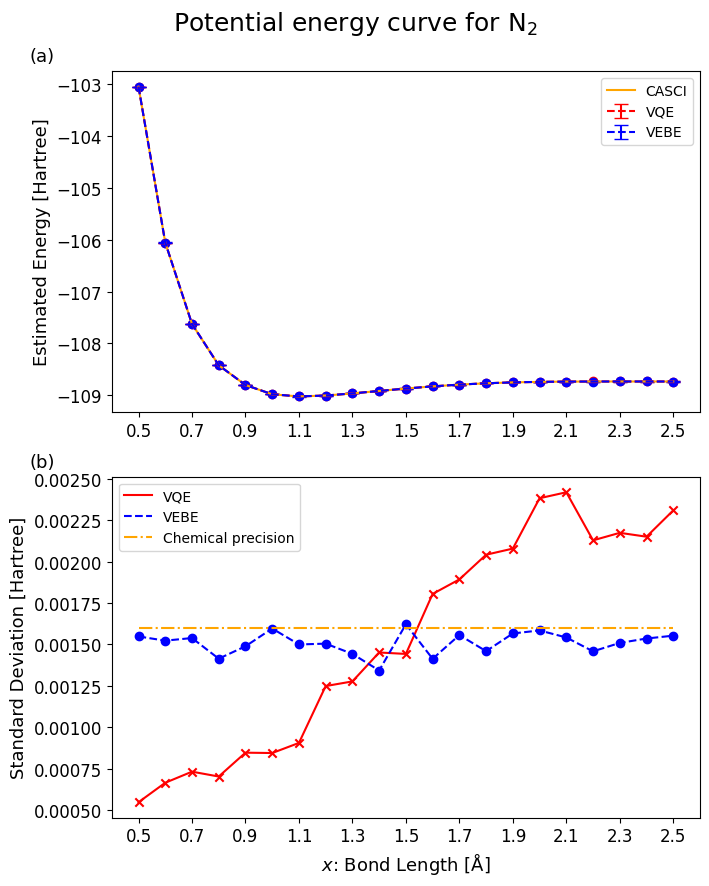

In [7]:
# === Step 5: Ilustrate graph of energy curve and unbiased standard deviation (Fig. 5) ===
fig, axes = plt.subplots(2, 1, figsize=(8, 9), sharex=False, sharey=False)

# === Step 5.1: Graph for comparironn of the energy curve ===
ax = axes[0]
ax.errorbar(dislist_2, energy_vqe_list, yerr=[std_vqe_list, std_vqe_list],
            linestyle='--', label='VQE', color='red', capsize=5)
ax.errorbar(dislist, np.real(energy_vebe_list), yerr=[np.real(std_vebe_list), np.real(std_vebe_list)],
            linestyle='--', label='VEBE', color='blue', capsize=5)
ax.scatter(dislist_2, energy_vqe_list, color='red')
ax.scatter(dislist, np.real(energy_vebe_list), color='blue')
ax.plot(dislist, casci_list, label='CASCI', color='orange', linestyle='-')

ax.set_ylabel("Estimated Energy [Hartree]", fontsize=13)
ax.set_xticks(np.arange(
    dislist_2[0],
    dislist_2[-1] + (dislist_2[-1] - dislist_2[0]) / len(dislist_2),
    2 * (dislist_2[-1] - dislist_2[0]) / (len(dislist_2) - 1)
))
ax.legend()
ax.tick_params(axis='both', labelsize=12)
ax.text(-0.14, 1.07, '(a)', transform=ax.transAxes,
        fontsize=13, va='top')

# === Step 5.2: Graph for comparison of the srtandard deviation ===
ax = axes[1]
ax.plot(dislist_2, std_vqe_list, linestyle='-', label='VQE', color='red')
ax.plot(dislist, np.real(std_vebe_list), linestyle='--', label='VEBE', color='blue')
ax.scatter(dislist_2, std_vqe_list, color='red', marker='x')
ax.scatter(dislist, np.real(std_vebe_list), color='blue')
ax.hlines(1.6e-3, dislist[0], dislist[-1], linestyles='-.', label='Chemical precision', color='orange')

ax.set_xlabel(r"$x$: Bond Length [Å]", fontsize=13)
ax.set_ylabel("Standard Deviation [Hartree]", fontsize=13)
ax.set_xticks(np.arange(
    dislist_2[0],
    dislist_2[-1] + (dislist_2[-1] - dislist_2[0]) / len(dislist_2),
    2 * (dislist_2[-1] - dislist_2[0]) / (len(dislist_2) - 1)
))
ax.tick_params(axis='both', labelsize=12)
ax.text(-0.14, 1.07, '(b)', transform=ax.transAxes,
        fontsize=13, va='top')
ax.legend()

# === Step 5.3: Plot and save figures ===
plt.suptitle(r"Potential energy curve for N$_2$", fontsize=18, x=0.45)
plt.tight_layout(rect=[0, 0, 0.9, 1])  
base_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
out_dir = os.path.join(
    base_dir, "..", "data", "pdf", "energy_curve", str(rhf_files[i][1])
)
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, f"nitro_{time}.pdf")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

In [8]:
# === Step 6: Print unbiased standard deviation ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(std_vqe_list)):
    print(std_vebe_list[i]**2, std_vqe_list[i]**2, dislist[i])

----- VEBE ----- ------ VQE ------ ---distance---
2.3973474154416413e-06 3.017094850969171e-07 0.5
2.319451538392285e-06 4.4441251090994753e-07 0.6
2.367992462323413e-06 5.37855183320614e-07 0.7
2.000419548236224e-06 4.958225069775691e-07 0.8
2.217224102648456e-06 7.188913048994486e-07 0.9
2.547911203558827e-06 7.153317659316511e-07 1.0
2.250093259944723e-06 8.219266676313602e-07 1.1
2.26499151065116e-06 1.5608427733449808e-06 1.2
2.0833489743532674e-06 1.6316577079064745e-06 1.3
1.8037833931780004e-06 2.1076737104637873e-06 1.4
2.629726091306809e-06 2.0821715518949597e-06 1.5
1.9984554558182058e-06 3.256677904658984e-06 1.6
2.4231661194256103e-06 3.5803257784184834e-06 1.7
2.130535349620306e-06 4.165184133454024e-06 1.8
2.453353642586408e-06 4.317599576723585e-06 1.9
2.5107677387977782e-06 5.670932866485128e-06 2.0
2.378407741319363e-06 5.843209820295889e-06 2.1
2.1273079045883523e-06 4.526237745954294e-06 2.2
2.2783530918318434e-06 4.72126856193325e-06 2.3
2.358880684359781e-06 4.620

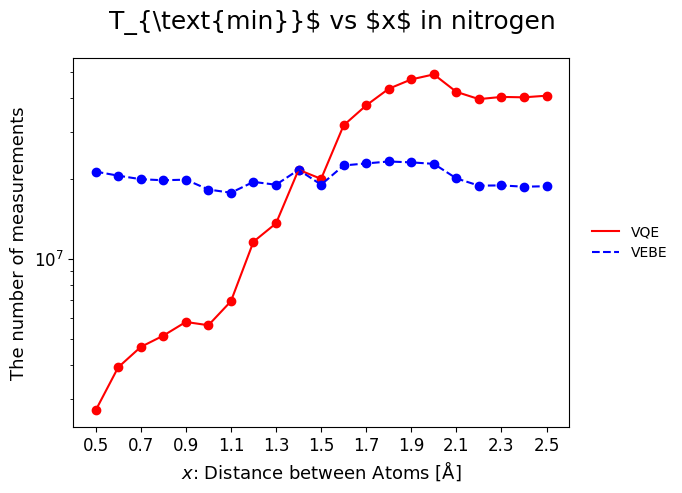

In [9]:
# === Step 7: Ilustrate graph of analytical necessary number of measurements (Fig.6) ===
fig, ax = plt.subplots()
ax.plot(dislist, np.array(num_vqe_list), label=r'VQE', linestyle='-', color='red')
ax.plot(dislist, np.array(num_vebe_list), label=r'VEBE', linestyle='--', color='blue')
ax.scatter(dislist, np.array(num_vqe_list), color='red')
ax.scatter(dislist, np.array(num_vebe_list), color='blue')
ax.set_yscale("log")
ax.legend()
ax.set_xlabel(r"$x$: Distance between Atoms [Å]", fontsize=13)
ax.set_ylabel(r"The number of measurements", fontsize=13)
ax.set_xticks(np.arange(
    dislist_2[0],
    dislist_2[-1] + (dislist_2[-1] - dislist_2[0]) / len(dislist_2),
    2 * (dislist_2[-1] - dislist_2[0]) / (len(dislist_2) - 1)
))
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=False)

base_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
out_dir = os.path.join(
    base_dir, "..", "data", "pdf", "number_of_measurement", str(rhf_files[i][1])
)
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, f"nitro_{time}.pdf")
plt.suptitle(r"T_{\text{min}}$ vs $x$ in nitrogen", fontsize=18, x=0.53)
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

In [10]:
# === Step 8: Print analytical necessary number of measurements ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(std_vqe_list)):
    print(num_vebe_list[i], np.array(num_vqe_list[i]), dislist[i])

----- VEBE ----- ------ VQE ------ ---distance---
21243394.35023975 2710413.1677609365 0.5
20508794.773911174 3929462.9092818294 0.6
19895694.45923965 4683043.515870794 0.7
19711717.815223943 5162700.722059212 0.8
19816782.962280743 5809900.838529896 0.9
18201654.47409704 5647633.56236767 1.0
17703345.970301356 6943867.465888813 1.1
19437445.72260893 11607678.76249699 1.2
18967074.506926954 13593361.074796647 1.3
21573929.60564764 21578072.541391227 1.4
18969251.597473253 19952043.963149153 1.5
22399875.711742792 31662888.07803723 1.6
22792102.590971544 37594770.3571417 1.7
23175002.996670254 43392595.62685363 1.8
23003164.368156366 47037291.08293038 1.9
22708315.300812032 49113602.63800547 2.0
20034710.50220581 42240818.03894504 2.1
18819245.42430613 39685776.01031481 2.2
18856940.513029102 40442245.676308624 2.3
18648482.21730238 40302573.106020756 2.4
18725294.601029605 40874031.43319679 2.5
